In [36]:

import matplotlib.pyplot as plt
from shapely import LineString
import segyio
from shapely import Point
#import gpd

In [18]:
def read_seismic_cube(file_path):
   """
   :param file_path: Путь к файлу
   :return: возвращает куб в виде списков по Inlines, Xlines и Sampels (координаты x, y, z)
   а также словарю сейсмотрасс, где ключ это координата пересечения Inlines и Xlines, а значение это список значений сейсмотрасс
   """
   with segyio.open(file_path, 'r') as segyfile:
       x = list(segyfile.ilines)
       y = list(segyfile.xlines)
       z = list(segyfile.samples)
       cube = segyio.tools.cube(segyfile)
       traces = {f"{x[i]}_{y[j]}": cube[i][j][:] for i in range(len(x)) for j in range(len(y))}
   return x, y, z, traces

In [19]:
file_path = 'D:/HV/seismika/datas/Cube_TWT.segy'
ilines, xlines, samples, traces = read_seismic_cube(file_path)

In [20]:
def extract_segy_data(file_path):
    with segyio.open(file_path, 'r') as segyfile:
        # Извлечение координат линий и образцов
        x = list(segyfile.ilines)
        y = list(segyfile.xlines)
        z = list(segyfile.samples)
        coord_x = set()
        coord_y = set()
        # Создание куба данных
        cube = segyio.tools.cube(segyfile)
        
        # Извлечение координат из заголовков
        traces = {}
        for i in range(len(x)):
            for j in range(len(y)):
                # Получение индекса записи
                index = i * len(y) + j
                
                # Получение данных записи
                trace_data = cube[i][j][:]
                
                # Извлечение заголовка записи
                trace_header = segyfile.header[index]
                
                # Получение координат X и Y из заголовка записи
                coord_x.add(trace_header[segyio.TraceField.SourceX])
                coord_y.add(trace_header[segyio.TraceField.SourceY])
        
    return coord_x, coord_y

In [22]:
file_path = 'D:/HV/seismika/datas/Cube_TWT.segy'
coord_x, coord_y = extract_segy_data(file_path)

In [23]:
# Перевод множества в упорядоченный список в порядке убывания
sorted_coord_x = sorted(coord_x, reverse=False)
sorted_coord_y = sorted(coord_y, reverse=False)
poligon_cub = [[sorted_coord_x[0], sorted_coord_y[0]], [sorted_coord_x[0], sorted_coord_y[-1]], [sorted_coord_x[-1], sorted_coord_y[-1]],[sorted_coord_x[-1], sorted_coord_y[0]], [sorted_coord_x[0], sorted_coord_y[0]]]

In [24]:
def process_file(file_path):
    # Множества для хранения значений
    x_set = set()
    y_set = set()
    z_set = set()
    
    with open(file_path, 'r') as file:
        for line in file:
            # Пропуск строк, начинающихся с "#"
            if line.startswith("#"):
                continue
            
            # Разделение строки на колонки
            columns = line.split()
            if len(columns) >= 5:
                # Получение значений из колонок
                x_value = columns[0]
                y_value = columns[1]
                z_value = columns[2]
                
                # Обработка значений
                x_set.add(int(x_value.split('.')[0]))
                y_set.add(int(y_value.split('.')[0]))
                z_set.add(int(z_value.lstrip('-').split('.')[0]))
    
    return x_set, y_set, z_set

In [25]:
file_path = 'D:/HV/seismika/datas/TWT_Bottom_U1.txt'  # Укажите путь к вашему файлу
x_set, y_set, z_set = process_file(file_path)

In [26]:
gorizont_x = sorted(x_set, reverse=False)
gorizont_y = sorted(y_set, reverse=False)
gorizont_z = sorted(z_set, reverse=False)
poligon_gorizont = [[gorizont_x[0], gorizont_y[0]], [gorizont_x[0], gorizont_y[-1]], [gorizont_x[-1], gorizont_y[-1]], [gorizont_x[-1], gorizont_y[0]], [gorizont_x[0], gorizont_y[0]]]

In [28]:
# Преобразование координат в объекты Point и LineString
points1 = [Point(xy) for xy in poligon_cub]
points2 = [Point(xy) for xy in poligon_gorizont]
line1 = LineString(poligon_cub)
line2 = LineString(poligon_gorizont)

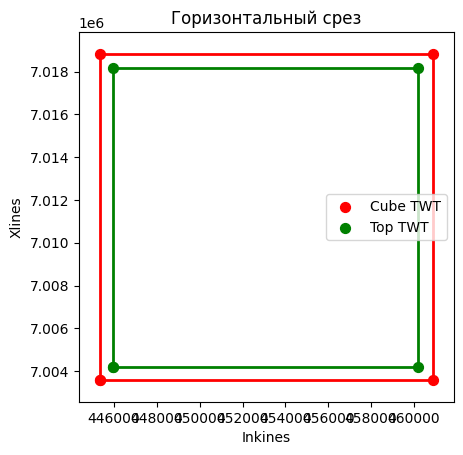

In [39]:
import geopandas as gpd
# Создание GeoDataFrame для точек и линий
gdf_points1 = gpd.GeoDataFrame({'geometry': points1})
gdf_points2 = gpd.GeoDataFrame({'geometry': points2})
#gdf_lines = gpd.GeoDataFrame({'geometry': [line1, line2]})
gdf_lines1 = gpd.GeoDataFrame({'geometry': [line1]})
gdf_lines2 = gpd.GeoDataFrame({'geometry': [line2]})

# Установка активной геометрической колонки
gdf_points1 = gdf_points1.set_geometry('geometry')
gdf_points2 = gdf_points2.set_geometry('geometry')
#gdf_lines = gdf_lines.set_geometry('geometry')
gdf_lines1 = gdf_lines1.set_geometry('geometry')
gdf_lines2 = gdf_lines2.set_geometry('geometry')

# Создание карты
fig, ax = plt.subplots()

# Отображение линий
#gdf_lines.plot(ax=ax, color='blue', linestyle='-', linewidth=2, edgecolor='black')

# Отображение линий с цветом точек
gdf_lines1.plot(ax=ax, color='red', linestyle='-', linewidth=2, edgecolor='black')
gdf_lines2.plot(ax=ax, color='green', linestyle='-', linewidth=2, edgecolor='black')

# Отображение точек
gdf_points1.plot(ax=ax, color='red', markersize=50, label='Cube TWT')
gdf_points2.plot(ax=ax, color='green', markersize=50, label='Top TWT')

# Настройка границ карты
ax.set_xlim(poligon_cub[0][0]-1000, poligon_cub[-2][0]+1000)
ax.set_ylim(poligon_cub[0][1]-1000, poligon_cub[1][1]+1000)

# Настройка меток и легенды
ax.set_xlabel('Inkines')
ax.set_ylabel('Xlines')
ax.set_title('Горизонтальный срез')
ax.legend()

plt.show()
